In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow-gpu==2.2.0
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
print(tf.test.gpu_device_name())

/device:GPU:0


In [13]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
########################################
np.random.seed(27)
tf.random.set_seed(27)
tf.compat.v1.reset_default_graph()
BATCH_SIZE = 200
EPOCHS = 100
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0.001, 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
def plot_metrics(history):
  metrics =  ['accuracy', 'precision', 'recall','F1_score']
  plt.figure(figsize=(10,8))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color="b", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color="r", linestyle="--", label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0.2,1])
    plt.legend(loc="best")


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.xlim(xmax = len(target_names)-0.5)
    plt.ylim(2.5,-0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    #plt.savefig('cm.pdf')
    plt.show()
def evaluate(predict):
    print("Test accuracy = ",sum(predict[0] == predict[1])/len(predict[0]))
    print("mu =" , np.mean(predict[0]-predict[1]))
    print("sigma = ",np.std(predict[0]-predict[1]))
    print("RMSE = ",np.sqrt(np.mean((predict[0]-predict[1])**2)))
    print("1st order poly fit:", np.polyfit(predict[0],predict[1],deg=1))

In [4]:
# load data  
# split train and test
from sklearn.model_selection import train_test_split
obsid_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_obsid.npy')
spectra_all = np.load('/content/drive/My Drive/CNN_spectra_data/LAMOST_dr5_SNR100_spectra.npy')
obsid_lumlabel = np.genfromtxt('/content/drive/My Drive/CNN_spectra_data/dr5_SNR100_obsid_lumlabel.csv'\
                                 ,delimiter=",",dtype=int)
unique_lum, counts = np.unique(obsid_lumlabel[:,1], return_counts = True)
print("classes and counts : ",dict(zip(unique_lum,counts)))
num_lum = max(unique_lum)-min(unique_lum)+1
print("number of diff classes = ", num_lum)
num_spectra = len(obsid_lumlabel)
spectra_NN = np.zeros((num_spectra,len(spectra_all[0])))
for i in range(num_spectra):
    index_of_spectra = np.where(obsid_all == obsid_lumlabel[i][0])
    spectra_NN[i] = spectra_all[index_of_spectra]
spectra_train, spectra_val_test, label_train, label_val_test = train_test_split(spectra_NN,
                                                    obsid_lumlabel[:,1] - min(unique_lum),
                                                    test_size = 0.2,
                                                    random_state = 27)


x_train = np.expand_dims(spectra_train,axis=2)
x_val_test = np.expand_dims(spectra_val_test,axis=2)
y_train = tf.one_hot(label_train, depth = 3, axis = 1 ,dtype=tf.int8)
y_val_test = tf.one_hot(label_val_test, depth = 3, axis = 1 ,dtype=tf.int8)

val_amount = int(len(x_val_test)/4)
x_val = x_val_test[:val_amount]
y_val = y_val_test[:val_amount]

x_test = x_val_test[val_amount:]
y_test = y_val_test[val_amount:]
label_test = label_val_test[val_amount:]
print(len(y_train))
print(len(y_val))
print(len(y_test))

classes and counts :  {2: 511, 3: 6193, 4: 8183}
number of diff classes =  3
11909
744
2234


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 4096, 1)           4         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              33562624  
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              16779264  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

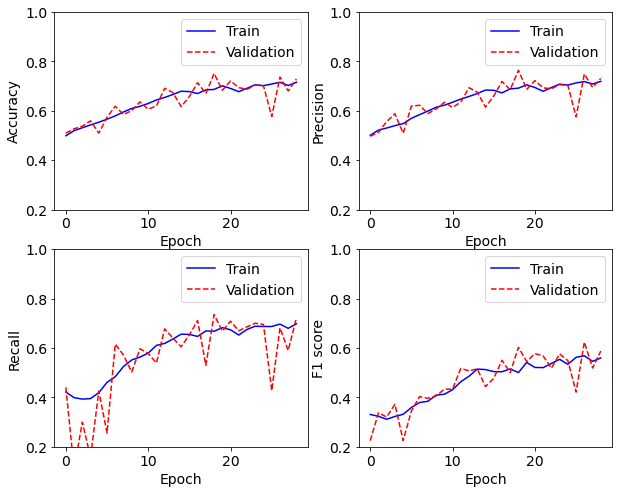

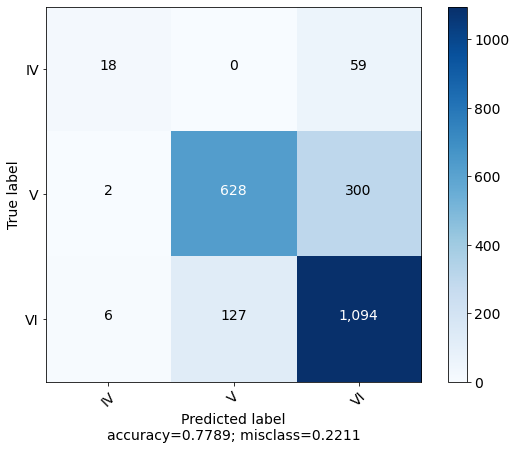

In [5]:
model_MLP = tf.keras.Sequential()
model_MLP.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_MLP.add(tf.keras.layers.Flatten())
model_MLP.add(tf.keras.layers.Dense(4096*2,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(2048,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(512,activation="relu"))
model_MLP.add(tf.keras.layers.Dropout(0.2))
model_MLP.add(tf.keras.layers.Dense(num_lum,activation="softmax")) #2 represent output layer neurons 
model_MLP.summary()
model_MLP.compile(loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall',\
                       tfa.metrics.F1Score(num_classes= 3,average="macro",name='F1_score',)])
MLP_hs = model_MLP.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))
print(MLP_hs.history.keys())

plot_metrics(MLP_hs)


prediction_MLP = model_MLP.predict(x_test)
predicted_label_MLP = np.zeros((len(label_test)))
for i in range(len(prediction_MLP)):
    predicted_label_MLP[i] = np.argmax(prediction_MLP[i])
cm_MLP = tf.math.confusion_matrix(label_test,predicted_label_MLP)
plot_confusion_matrix(np.array(cm_MLP), ["IV","V","VI"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_cm/lum_MLP_cm.npy', cm_MLP)
np.save('/content/drive/My Drive/CNN_prediction/lum_MLP_predict.npy', np.vstack([label_test,predicted_label_MLP]))

In [16]:
evaluate(np.vstack([label_test,predicted_label_CW]))

Test accuracy =  0.8348254252461952
mu = 0.07162041181736795
sigma =  0.47239875029361683
RMSE =  0.477797093615962
1st order poly fit: [0.74911042 0.30842003]


In [6]:
"""
CNN model
"""
model_CNN = tf.keras.Sequential()
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1,input_shape =(len(spectra_NN[0]),1)))
model_CNN.add(tf.keras.layers.Conv1D(filters=16,kernel_size=8,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Conv1D(filters=32,kernel_size=4,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Conv1D(filters=64,kernel_size=4,padding="valid",activation="relu"))
model_CNN.add(tf.keras.layers.MaxPooling1D(pool_size=4))
model_CNN.add(tf.keras.layers.Flatten())
#model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
#model_CNN.add(tf.keras.layers.Dense(1024,activation="relu"))
#model_CNN.add(tf.keras.layers.Dropout(0.2))
#model_CNN.add(tf.keras.layers.BatchNormalization(axis=-1))
model_CNN.add(tf.keras.layers.Dense(512,activation="relu"))
model_CNN.add(tf.keras.layers.Dropout(0.2))
model_CNN.add(tf.keras.layers.Dense(3,activation="softmax")) #2 represent output layer neurons 
model_CNN.summary()
model_CNN.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','Precision','Recall',\
                       tfa.metrics.F1Score(num_classes= 3,average="macro",name='F1_score',)])
initial_weights = model_CNN.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 4096, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 4089, 16)          144       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1022, 16)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1022, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1019, 32)          2080      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 254, 32)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 254, 32)          

Epoch 1/100
60/60 [==============================] - 2s 30ms/step - loss: 1.0014 - accuracy: 0.5418 - precision: 0.5488 - recall: 0.4931 - F1_score: 0.3401 - val_loss: 0.9826 - val_accuracy: 0.5094 - val_precision: 0.4366 - val_recall: 0.0417 - val_F1_score: 0.2250
Epoch 2/100
60/60 [==============================] - 1s 17ms/step - loss: 0.7094 - accuracy: 0.6513 - precision: 0.6583 - recall: 0.6179 - F1_score: 0.4220 - val_loss: 1.0273 - val_accuracy: 0.5148 - val_precision: 0.4000 - val_recall: 0.0054 - val_F1_score: 0.2469
Epoch 3/100
60/60 [==============================] - 1s 17ms/step - loss: 0.6191 - accuracy: 0.7207 - precision: 0.7276 - recall: 0.7053 - F1_score: 0.5000 - val_loss: 0.9992 - val_accuracy: 0.3723 - val_precision: 0.6000 - val_recall: 0.1048 - val_F1_score: 0.3330
Epoch 4/100
60/60 [==============================] - 1s 17ms/step - loss: 0.5605 - accuracy: 0.7576 - precision: 0.7620 - recall: 0.7480 - F1_score: 0.5829 - val_loss: 0.9931 - val_accuracy: 0.3562 - va

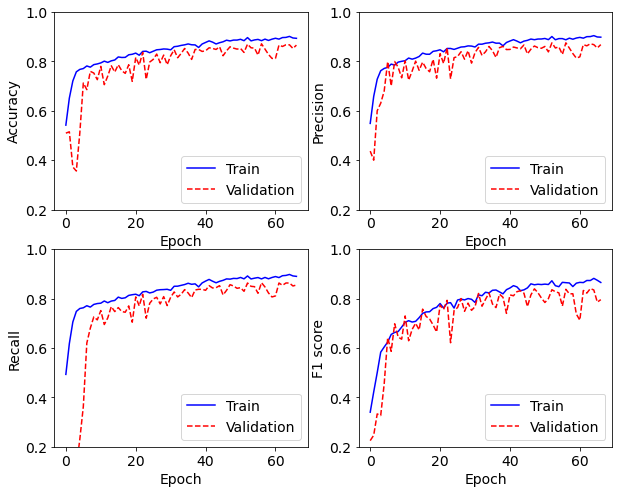

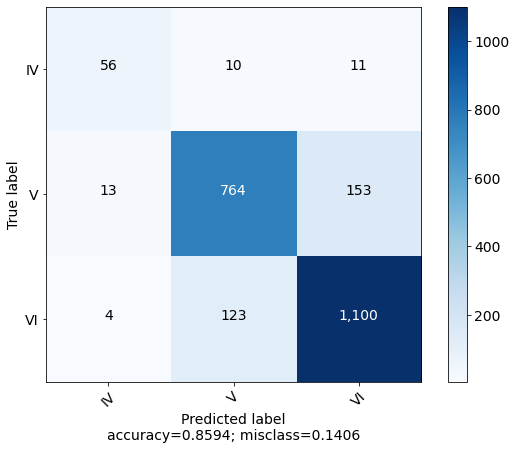

In [7]:
"""
Basic CNN
"""

model_CNN.set_weights(initial_weights)
Basic_hs = model_CNN.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val)
          )
#test_accuracy = model_CNN.evaluate(x_test, y_test, verbose=0)
#print('\n', 'Test_Accuracy = ', test_accuracy[1])
#model_CNN.save('CNN_LAMOST.h5')

plot_metrics(Basic_hs)
prediction_CNN = model_CNN.predict(x_test)
predicted_label_CNN = np.zeros((len(label_test)))
for i in range(len(prediction_CNN)):
    predicted_label_CNN[i] = np.argmax(prediction_CNN[i])
cm_CNN = tf.math.confusion_matrix(label_test,predicted_label_CNN)
plot_confusion_matrix(np.array(cm_CNN), ["IV","V","VI"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_cm/lum_CNN_basic_cm.npy', cm_CNN)
np.save('/content/drive/My Drive/CNN_prediction/lum_CNN_basic_predict.npy', np.vstack([label_test,predicted_label_CNN]))

{0: 5.442828135211761, 1: 1.5542260650425364, 2: 1.3456240070594159}
Epoch 1/100
60/60 [==============================] - 1s 17ms/step - loss: 2.0929 - accuracy: 0.4929 - precision: 0.4913 - recall: 0.2152 - F1_score: 0.3308 - val_loss: 1.0040 - val_accuracy: 0.5269 - val_precision: 1.0000 - val_recall: 0.0013 - val_F1_score: 0.2831
Epoch 2/100
60/60 [==============================] - 1s 17ms/step - loss: 1.4886 - accuracy: 0.5256 - precision: 0.5158 - recall: 0.1370 - F1_score: 0.3398 - val_loss: 1.0452 - val_accuracy: 0.5108 - val_precision: 1.0000 - val_recall: 0.0013 - val_F1_score: 0.2290
Epoch 3/100
60/60 [==============================] - 1s 17ms/step - loss: 1.3843 - accuracy: 0.5618 - precision: 0.5736 - recall: 0.2684 - F1_score: 0.4302 - val_loss: 1.2056 - val_accuracy: 0.2204 - val_precision: 0.0700 - val_recall: 0.0242 - val_F1_score: 0.2094
Epoch 4/100
60/60 [==============================] - 1s 17ms/step - loss: 1.2435 - accuracy: 0.5934 - precision: 0.6034 - recall: 0.4

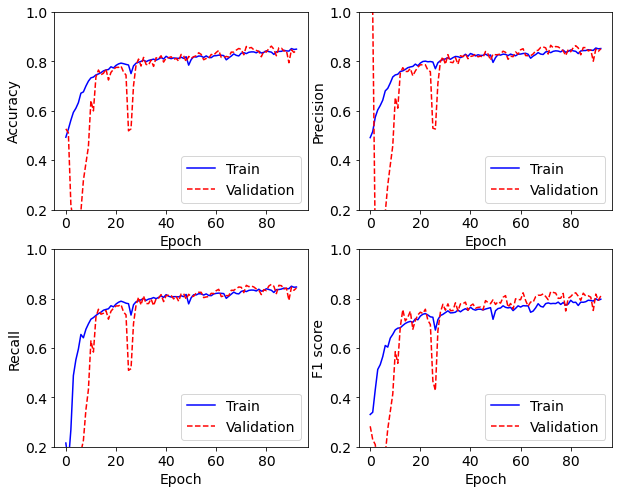

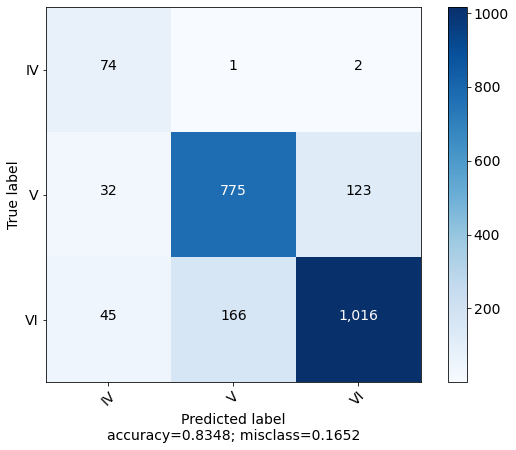

In [8]:
"""
Class weightening
"""
unique_label, counts_label_train = np.unique(label_train,return_counts= True)

class_weights_num = np.sqrt(1/counts_label_train * len(label_train))
class_weights = dict(zip(unique_label,class_weights_num))
print(class_weights)


model_CNN.set_weights(initial_weights)
CW_hs = model_CNN.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val),
          class_weight = class_weights)
plot_metrics(CW_hs)

prediction_CW = model_CNN.predict(x_test)
predicted_label_CW = np.zeros((len(label_test)))
for i in range(len(prediction_CW)):
    predicted_label_CW[i] = np.argmax(prediction_CW[i])
cm_CW = tf.math.confusion_matrix(label_test,predicted_label_CW)
plot_confusion_matrix(np.array(cm_CW), ["IV","V","VI"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_cm/lum_CNN_cw_cm.npy', cm_CW)
np.save('/content/drive/My Drive/CNN_prediction/lum_CNN_cw_predict.npy', np.vstack([label_test,predicted_label_CW]))

classify data into list is done
processing class : 0
processing class : 1
processing class : 2
Epoch 1/100
75/75 [==============================] - 1s 17ms/step - loss: 1.3735 - accuracy: 0.4165 - precision: 0.4908 - recall: 0.1071 - F1_score: 0.4115 - val_loss: 1.3746 - val_accuracy: 0.1358 - val_precision: 0.0569 - val_recall: 0.0336 - val_F1_score: 0.1420
Epoch 2/100
75/75 [==============================] - 1s 17ms/step - loss: 0.8337 - accuracy: 0.5881 - precision: 0.6955 - recall: 0.3679 - F1_score: 0.5638 - val_loss: 2.6025 - val_accuracy: 0.0968 - val_precision: 0.0510 - val_recall: 0.0444 - val_F1_score: 0.0985
Epoch 3/100
75/75 [==============================] - 1s 16ms/step - loss: 0.7087 - accuracy: 0.6476 - precision: 0.7010 - recall: 0.5022 - F1_score: 0.6104 - val_loss: 3.2611 - val_accuracy: 0.0672 - val_precision: 0.0459 - val_recall: 0.0430 - val_F1_score: 0.0582
Epoch 4/100
75/75 [==============================] - 1s 17ms/step - loss: 0.6748 - accuracy: 0.6705 - preci

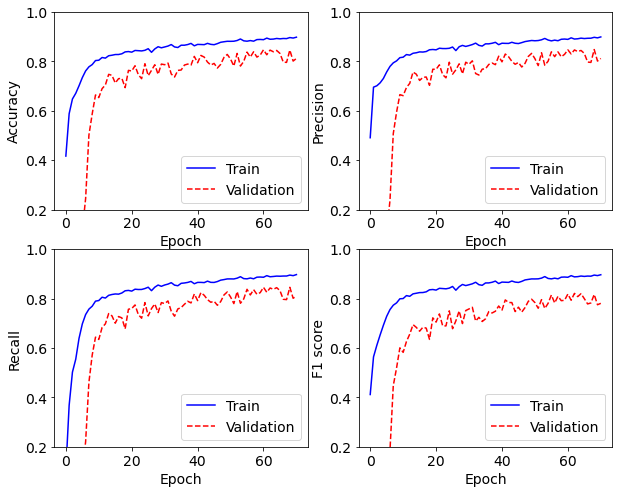

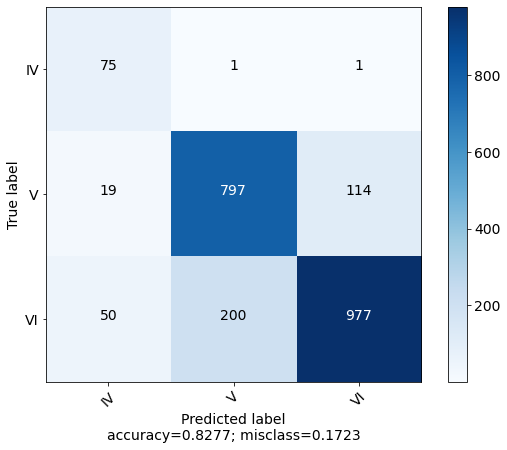

In [9]:
"""
Oversampling 
"""
target_num = 5000
x_classed = [ [] for _ in range(3)]
y_classed = [ [] for _ in range(3)]
for i in range(len(x_train)):
    x_classed[label_train[i]].append(x_train[i])
    y_classed[label_train[i]].append(y_train[i])
print("classify data into list is done")

resampled_x = np.empty((0,4096,1))
resampled_y = np.empty((0,3))
for j in range(3):
    choices = np.random.choice(len(x_classed[j]),target_num)
    print("processing class :" ,j)
    for k in range(len(choices)):
        one_train_x = x_classed[j][choices[k]]
        one_train_y = y_classed[j][choices[k]]
        one_train_x = np.expand_dims(one_train_x,axis=0)
        one_train_y = np.expand_dims(one_train_y,axis=0)
        resampled_x = np.concatenate([resampled_x,one_train_x],axis = 0)
        resampled_y = np.concatenate([resampled_y,one_train_y],axis = 0)

order = np.arange(len(resampled_y))
np.random.shuffle(order)
resampled_x= resampled_x[order]
resampled_y = resampled_y[order]
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(resampled_x, resampled_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))
plot_metrics(re_hs)

prediction_re = model_CNN.predict(x_test)
predicted_label_re = np.zeros((len(label_test)))
for i in range(len(prediction_re)):
    predicted_label_re[i] = np.argmax(prediction_re[i])
cm_re= tf.math.confusion_matrix(label_test,predicted_label_re)
plot_confusion_matrix(np.array(cm_re), ["IV","V","VI"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_cm/lum_CNN_oversample_cm.npy', cm_re)
np.save('/content/drive/My Drive/CNN_prediction/lum_CNN_oversample_predict.npy', np.vstack([label_test,predicted_label_re]))

data processed
Epoch 1/100
99/99 [==============================] - 2s 17ms/step - loss: 1.0860 - accuracy: 0.5578 - precision: 0.6188 - recall: 0.3685 - F1_score: 0.5461 - val_loss: 1.4768 - val_accuracy: 0.1398 - val_precision: 0.0664 - val_recall: 0.0444 - val_F1_score: 0.1393
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.6193 - accuracy: 0.7240 - precision: 0.7435 - recall: 0.6827 - F1_score: 0.7115 - val_loss: 3.0903 - val_accuracy: 0.0780 - val_precision: 0.0704 - val_recall: 0.0672 - val_F1_score: 0.0690
Epoch 3/100
99/99 [==============================] - 2s 16ms/step - loss: 0.5436 - accuracy: 0.7722 - precision: 0.7816 - recall: 0.7576 - F1_score: 0.7670 - val_loss: 3.3068 - val_accuracy: 0.1062 - val_precision: 0.0933 - val_recall: 0.0874 - val_F1_score: 0.0952
Epoch 4/100
99/99 [==============================] - 2s 16ms/step - loss: 0.4953 - accuracy: 0.8053 - precision: 0.8138 - recall: 0.7950 - F1_score: 0.8015 - val_loss: 2.4408 - val_accura

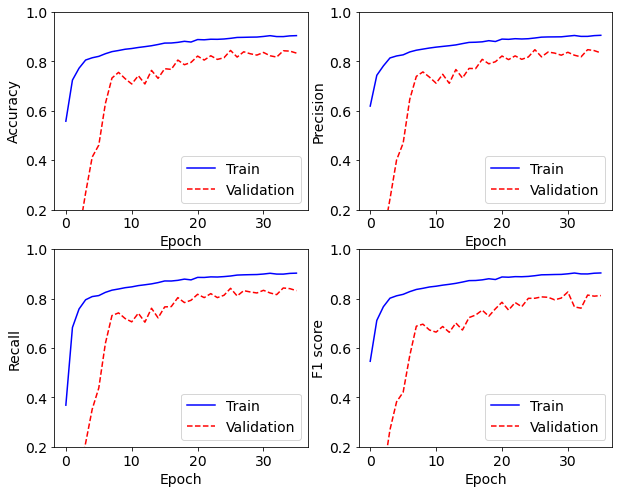

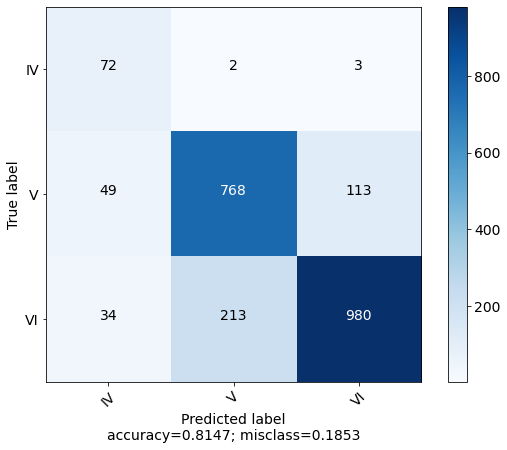

In [10]:
"""
Smote sampling
"""


spectra_smote = np.load("/content/drive/My Drive/CNN_spectra_data/lum_spectra_smote.npy")
label_smote = np.load("/content/drive/My Drive/CNN_spectra_data/lum_label_smote.npy")
x_smote = np.expand_dims(spectra_smote, axis=2)
y_smote = tf.one_hot(label_smote, depth = 3, axis = 1 ,dtype=tf.int8)
print("data processed")
model_CNN.set_weights(initial_weights)
re_hs = model_CNN.fit(x_smote, y_smote,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks = [early_stop],
          validation_data=(x_val, y_val))
#model_CNN.save("/content/drive/My Drive/CNN_models/lum_class_model")
tf.saved_model.save( model_CNN, "/content/drive/My Drive/CNN_models/lum_class_model")

plot_metrics(re_hs)

prediction_smote = model_CNN.predict(x_test)
predicted_label_smote = np.zeros((len(label_test)))
for i in range(len(prediction_smote)):
    predicted_label_smote[i] = np.argmax(prediction_smote[i])
cm_smote= tf.math.confusion_matrix(label_test,predicted_label_smote)
plot_confusion_matrix(np.array(cm_smote), ["IV","V","VI"], title = "Confusion Matrix of the final model")
#np.save('/content/drive/My Drive/CNN_cm/lum_CNN_smote_cm.npy', cm_smote)
np.save('/content/drive/My Drive/CNN_prediction/lum_CNN_smote_predict.npy', np.vstack([label_test,predicted_label_smote]))

In [17]:
evaluate(np.vstack([label_test,predicted_label_smote]))

Test accuracy =  0.8146821844225605
mu = 0.09355416293643688
sigma =  0.4756596418375236
RMSE =  0.4847726026455482
1st order poly fit: [0.74521135 0.29239248]


In [12]:
"""
'''
Oversampling with tf database
'''

BUFFER_SIZE = 20000


def make_ds(features, labels, target_num):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat(np.ceil(target_num/len(labels)))
  return ds

x_classed = [[]]*5
y_classed = [[]]*5
for i in range(len(x_train)):
    x_classed[label_train[i]].append(x_train[i])
    y_classed[label_train[i]].append(y_train[i])
print("classify data done")
data_classed=[]
for j in range(5):
    data_classed.append(make_ds(x_classed[j],y_classed[j], target_num = 20000))
print("make_ds done")

resampled_ds = tf.data.experimental.sample_from_datasets(data_classed, weights=[1/5]*5)
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(10)
resampled_steps_per_epoch = np.ceil(BUFFER_SIZE/(BATCH_SIZE*0.2))

"""

'\n\'\'\'\nOversampling with tf database\n\'\'\'\n\nBUFFER_SIZE = 20000\n\n\ndef make_ds(features, labels, target_num):\n  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()\n  ds = ds.shuffle(BUFFER_SIZE).repeat(np.ceil(target_num/len(labels)))\n  return ds\n\nx_classed = [[]]*5\ny_classed = [[]]*5\nfor i in range(len(x_train)):\n    x_classed[label_train[i]].append(x_train[i])\n    y_classed[label_train[i]].append(y_train[i])\nprint("classify data done")\ndata_classed=[]\nfor j in range(5):\n    data_classed.append(make_ds(x_classed[j],y_classed[j], target_num = 20000))\nprint("make_ds done")\n\nresampled_ds = tf.data.experimental.sample_from_datasets(data_classed, weights=[1/5]*5)\nresampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(10)\nresampled_steps_per_epoch = np.ceil(BUFFER_SIZE/(BATCH_SIZE*0.2))\n\n'